# Libraries

In [1]:
import os
import sys
import glob
import pickle
import shutil

import numpy as np
import pandas as pd

import scipy
import scipy.signal
from scipy.signal    import savgol_filter


from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS


import matplotlib.pyplot as plt
import matplotlib        as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import more_itertools as mit
from pathlib import Path

In [2]:
sns.set_context('paper')
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Display all colums
pd.set_option('display.max_columns', None)

# Paths

In [ ]:
base = Path.home()
askap = base / 'ANU' / 'ASKAP'
data_path = askap / 'data'
LMC_data_path = data_path / 'LMC'
LMC_GASKAP_data = LMC_data_path / 'lmc_gaskap'

LMC_bridge_data = LMC_data_path / 'bridge'
GASS_data_path = LMC_data_path / 'GASS'

SMC = askap / 'SMC'
SMC_data_path = data_path / 'SMC'
SMC_fg_data_path = SMC_data_path / 'fg'
SMC_fg_abs_data_path = SMC_fg_data_path / 'spectra'


hires_data = LMC_data_path / 'hires'
hires_em_data = hires_data / 'cube'
hires_results = hires_data / 'results'
hires_result_figpath = hires_results / 'figs'
hires_abs_data = hires_data / 'abs'
hires_em_profile_path = hires_data / 'em_profiles'
abscatv2_data_path = hires_data / 'abscatv2'
abs_dr3_data_path = hires_data / 'absdr3'

mwmc_data_path = data_path / 'mwmc'
mwmc_gaskap_path = mwmc_data_path / 'lmc_gaskap'

bridge_hires_abs_data = hires_abs_data / 'bridge'
LMC_hires_abs_data = hires_abs_data / 'lmc'
abs_dr3_data_path = hires_data / 'absdr3'

abs_path = mwmc_data_path / 'absorption'

# Modules

In [ ]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(Path(script_dir) / os.pardir)
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = Path(parent_dir) / 'gaussfit'
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = Path(parent_dir) / 'gaussfit' / 'modules'
sys.path.append(module_dir)

print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
print('gaussfit_dir: ', gaussfit_dir)

In [5]:
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf
from mpfit import mpfit

# For plotting

In [6]:
# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = cf.SMC['circ']
LMC_xcirc, LMC_ycirc = cf.LMC['circ']

In [7]:
# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.88*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

In [8]:
lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Fcn

In [11]:
def detect_peaks_with_em_profiles(xa,
                                  ya,
                                  sigya,
                                  xe,
                                  em_profiles,
                                  peak_ids,
                                 ):
    # Noise
    nchan, npix = em_profiles.shape
    em_noise = em_profiles[-60:, :]
    sigem = np.max(np.std(em_noise, axis=0))
    em_sig_thresh = 1.*sigem
    
    #
    peak_idx = []
    keep_idx = []
    for j, idx in enumerate(peak_ids):
        # Peaks at the two ends of a spectrum: Remove? keep for now.
        if idx == 0:
            idx += 1
        if idx == len(ya)-1:
            idx -= 1

        # 5-signma emission condition
        # here: check not satisfy
        xa_ref   = xa[idx]
        xe_idx   = np.abs(xe-xa_ref).argmin()
        em_profile_val = [em_profiles[xe_idx][pid] for pid in range(npix)]
        em_profile_val = np.asarray(em_profile_val)
        cond_5sigma_em = np.any(em_profile_val < em_sig_thresh)
        
        # here: check not satisfy 
        if cond_5sigma_em:
            pass # remove this peak
        else:
            peak_idx.append(idx)
            keep_idx.append(j)
    
    # return:
    # peak_idx from SMC criteria
    # SMC criteria + 5-sigma emission couterpart 
    return peak_idx






def get_init_abs_guesses(x, y, yerr, peak_ids):
    '''
    Estimate the initial guesses (tau_0, cen0, wid0)
    - Flip the e^(-tau) profile
    - Get the values around a peak (low and high)
    - Subtract these values by nsig
    - Find the first negative values of the difference
    
    Note:
    - wid_nchans should be large enough (depending on the VLSR grid)
    - use nsig=1, 1.5, 2, I think.
    '''
    hgt0 = list(np.round(y[peak_ids],5))
    cen0 = list(np.round(x[peak_ids],1))
    
    wid0 = np.zeros(len(peak_ids))
    widsign = np.zeros(len(peak_ids))
    wid_nchans = 15 # large enough 20
    nsig = 3.
    for k,peak_id in enumerate(peak_ids):
        chan_low = peak_id - wid_nchans
        chan_high = peak_id + wid_nchans
        
        ydiff_low = y[chan_low:peak_id+1] - nsig*yerr[chan_low:peak_id+1]
        ydiff_high = y[peak_id:chan_high] - nsig*yerr[peak_id:chan_high]

        xid_low = peak_id - (wid_nchans - np.where(ydiff_low < 0)[0][-1])
        xid_high = peak_id + np.where(ydiff_high < 0)[0][0]
        
        wid0i = np.abs(x[xid_low] - x[xid_high])
        wid0[k] = round(wid0i,3)
        
        widsign[k] = 1. if (np.abs(x[xid_low]-x[peak_id])) <= (np.abs(x[xid_high]-x[peak_id])) else -1.
    # Endfor
    
    # Find duplicates
    # If same widths, there should be 2 or more peaks
    dup_xids = [idx for idx, item in enumerate(wid0) if item in wid0[:idx]]
    
    for xid in dup_xids:
        dup_xid = np.where(wid0 == wid0[xid])[0]
        wid0[dup_xid] = wid0[dup_xid]/len(dup_xid)
    # Endfor
    
    wid0 = list(wid0)
    
    xhgt0 = []
    xcen0 = []
    xwid0 = []
    for i,(hgti,ceni,widi) in enumerate(zip(hgt0, cen0, wid0)):
        if widi >= 6.:
            wid0[i] = 5.
            xcen0.append(ceni + 2.5*widsign[i])
            xwid0.append(5.)
            xhgt0.append(hgti/3.)
        
        if (widi>2.8) and (widi<7.):
            wid0[i] = widi/2.
    
    hgt0 += xhgt0
    cen0 += xcen0
    wid0 += xwid0
    
    wid0 = [round(wi,0) for wi in wid0]
    wid0 = [1. if wi == 0. else wi for wi in wid0]
    hgt0 = [np.round(-np.log(1.-hgti),3) for hgti in hgt0]
    cen0 = [np.round(cen0i, 1) for cen0i in cen0]
    
    peak_ids = [(np.abs(x-xi)).argmin() for xi in cen0]
    
    return hgt0, cen0, wid0, peak_ids



def detect_peaks(x, y, y_std):
    # 3-sigma condition
    nsig = 3.
    nsig_nb = 2.8
    peak_ids = np.where(y < 1.-nsig*y_std)[0]
    
    peak_idx = []
    for idx in peak_ids:
        # Peaks at the two ends of a spectrum: Remove? keep for now.
        if idx == 0:
            idx += 1
        if idx == len(y)-1:
            idx -= 1
        
        if np.abs(x[idx] >= 50.):
            continue

        # adjacent channels of at least 2.8σ significance
        if (1.-y[idx+1] <= nsig_nb*y_std[idx+1]) and (1.-y[idx-1] <= nsig_nb*y_std[idx-1]):
            pass # remove these peaks
        else:
            peak_idx.append(idx)
    
    peak_groups = [list(group) for group in mit.consecutive_groups(peak_idx)]
    
    # Find peaks with scipy.signal.find_peaks
    # Typically the minimum width of CNM clouds is ~2km/s.
    max_noise = np.max(y_std) # max 1-sigma
    peaks, props = scipy.signal.find_peaks(1.-y, distance=2., height=np.median(y_std)) # distance=??. km/s
    
    # Incorprate the two criteria, and find the common peaks
    common_peak_ids = sorted(list(set(peaks).intersection(peak_idx)))[::-1]
    
    # return:
    # peak_idx from SMC criteria
    # peak_groups from SMC criteria
    # common_peak_ids: SMC criteria + scipy.signal.find_peaks
    return common_peak_ids, peak_idx, peak_groups

# Read table DR3

In [ ]:
spectra_filename = mwmc_data_path / 'gaskap_phase2_unique_spectra_v0.2c.csv'
spectra_filename = abs_dr3_data_path / 'gaskap_abs_spectra_dr3b.csv'
print(spectra_filename)
df = pd.read_csv(spectra_filename)
nsrcs, ncols = df.shape
print(f'Number of rows {nsrcs},\n Number of columns: {ncols}')
df.head(5)

In [16]:
field_ids = df['sbid'].unique()
print(f'Number of fields: {len(field_ids)}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [17]:
print(f"Types of ratings: {df['rating'].unique()}")

Types of ratings: ['A' 'B' 'C' 'D']


In [18]:
df.groupby(['rating'])['comp_name'].count()

rating
A     294
B    1869
C     343
D     208
Name: comp_name, dtype: int64

In [19]:
# All sources
sources = df['comp_name'].unique()
print(f'Number of sources toward LMC: {len(sources)}')
print(f'Sources: {sources}')

Number of sources toward LMC: 2714
Sources: ['J005611-710706' 'J011049-731427' 'J011056-731406' ... 'J045340-751015'
 'J060302-715904' 'J051901-715032']


In [20]:
field_ids = df['sbid'].unique()
nfields = len(field_ids)
print(f'Number of fields: {nfields}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [21]:
src_ra = df['ra'].values
src_dec = df['dec'].values

src_gl = df['glon'].values
src_gb = df['glat'].values

src_list = df['comp_name'].values
print(len(src_list))

2714


# Absorption peak catalogue

In [44]:
peak_cat_dr3_file = abs_dr3_data_path / 'gaskap_absorption_v0.3b.vot'
abs_df = fcn.votable_to_pandas(peak_cat_dr3_file)
nrows, ncols = abs_df.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
abs_df.head(5)

Number of rows 1059,
 Number of columns: 27


,src_id,sbid,comp_name,abs_name,ra,dec,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,start_vel,end_vel,length,min_optical_depth,e_min_optical_depth,peak_tau,e_peak_tau,max_sigma,ew,e_ew
0,0,30665,J005611-710706,J005611-710706_150,14.047482,-71.118446,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.80,4.215,33.869999,150.673036,138.946946,13,0.913717,0.005705,0.090235,0.006225,15.122845,0.686081,0.020185
1,0,30665,J005611-710706,J005611-710706_1,14.047482,-71.118446,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.80,4.215,33.869999,1.165389,-2.743308,5,0.898914,0.005135,0.106568,0.005696,19.687183,0.255683,0.011083
2,8,30665,J011049-731427,J011049-731427_179,17.707468,-73.240921,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,179.075688,177.121334,3,0.959491,0.007145,0.041352,0.007419,5.669699,0.101240,0.012342
3,8,30665,J011049-731427,J011049-731427_175,17.707468,-73.240921,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,175.166980,173.212625,3,0.959115,0.007647,0.041744,0.007942,5.346187,0.110211,0.013172
4,8,30665,J011049-731427,J011049-731427_171,17.707468,-73.240921,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.79,5.350,54.860001,171.258271,150.737551,22,0.547128,0.008093,0.603072,0.014683,55.958978,5.948881,0.036829


In [ ]:
# Read .vot tables
filename = field_spectra_dir / (source + '_spec.vot')
print(filename)
data = fcn.votable_to_pandas(filename)
print(f'spectral shape: {data.shape}')
nchan = data.shape[0]
data.head()

In [53]:
abs_vlsr = data['velocity'].values/1000. # to km/s
Tem      = data['em_mean'].values
Tem_std  = data['em_std'].values

emt     = data['optical_depth'].values
emt_std = data['sigma_od'].values

emt_smooth = data['smoothed_od'].values
emt_std_smooth = data['sigma_smoothed_od'].values

flux = data['flux'].values

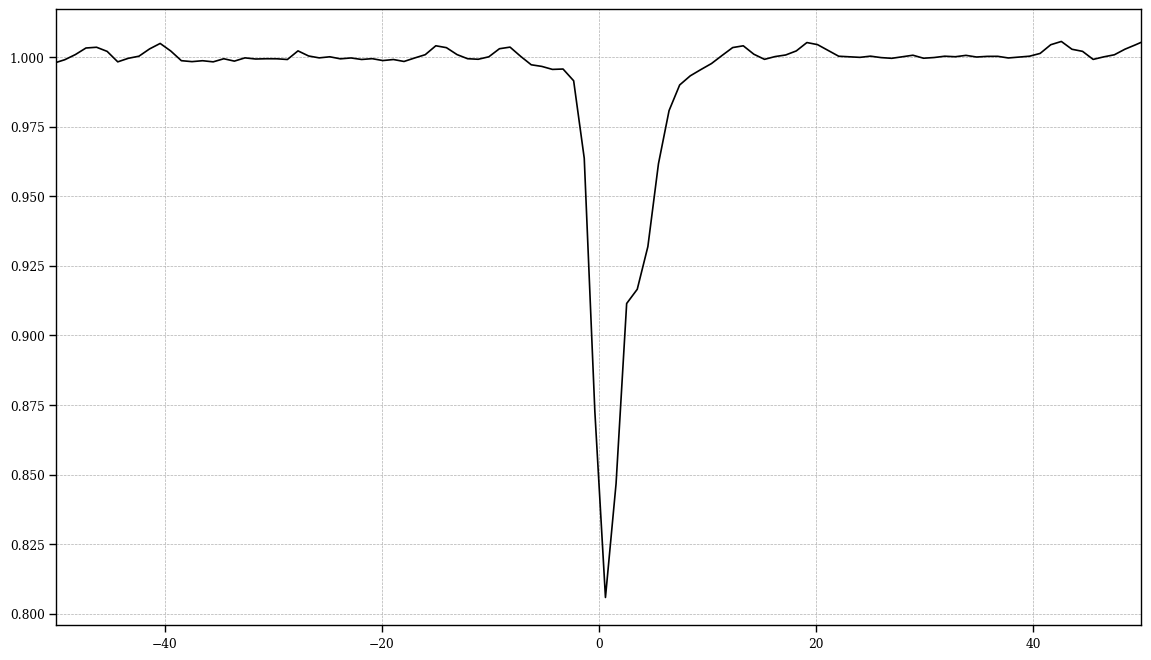

In [56]:

plt.figure(figsize=(14,8))
plt.plot(abs_vlsr, emt, 'k-')
plt.xlim(-50, 50)
plt.xlim(-50, 50)
plt.grid(ls='--', lw=0.5)
plt.show()